In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dask.array as darray
import xarray as xr

from ddc import DataLorenz96

In [2]:
import sys
sys.path.append("..")
from esnpy import LazyESN, from_zarr

In [3]:
data = DataLorenz96(system_dimension=64)
# spinup the dynamics
data.generate(n_steps=2_000)
# generate the training data
data.generate(n_steps=42_000)

In [4]:
ldata = darray.from_array(data.values, chunks=(4,-1), asarray=False)

In [5]:
esn = LazyESN(
    data_chunks=ldata.chunksize,
    n_reservoir=500,
    overlap={0:2, 1:0},
    boundary="periodic",
    persist=True,
    input_factor=0.863,
    adjacency_factor=0.713,
    connectedness=5,
    bias=1.76,
    leak_rate=0.874,
    tikhonov_parameter=6.9e-7,
    input_kwargs={
        "normalization": "svd",
    },
    random_seed=0,
)

In [6]:
esn

ESN
    n_input:                8
    n_output:               4
    n_reservoir:            500
--- 
    connectedness:          5
    bias:                   1.76
    leak_rate:              0.874
    tikhonov_parameter:     6.9e-07
--- 
    random_seed:            0
    random_state:           RandomState(MT19937)
--- 
    Input Matrix:
        factor              0.863
        distribution        uniform
        normalization       svd
        is_sparse           False
--- 
    Adjacency Matrix:
        factor              0.713
        density             0.01
        distribution        uniform
        normalization       eig
        is_sparse           True
        format              csr

In [7]:
esn.build()

In [8]:
%%time
esn.train(ldata, batch_size=10_000)

CPU times: user 58.6 s, sys: 41.9 s, total: 1min 40s
Wall time: 29.3 s


In [9]:
esn.Wout

dask.array<_train_nd, shape=(4, 8000), dtype=float64, chunksize=(4, 500), chunktype=numpy.ndarray>

In [10]:
v = esn.predict(ldata, n_steps=500, n_spinup=500)

In [11]:
u = ldata[:, 500:500+v.shape[-1]]

In [12]:
time = data.delta_t*np.arange(v.shape[-1])

Only plot the first 6 dimensions

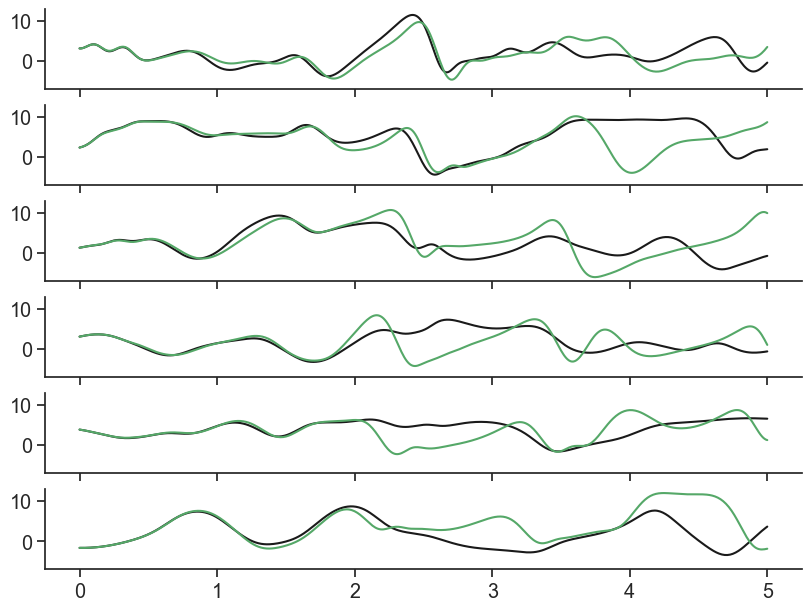

In [13]:
nrows = 6 #data.system_dimension
fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows*1), constrained_layout=True, sharex=True, sharey=True)

for ui, vi, ax in zip(u, v.squeeze(), axs):
    ax.plot(time, ui, color='k')
    ax.plot(time, vi, color="C2")
    for key in ["top", "right"]:
        ax.spines[key].set_visible(False)

## Save and re-load

In [14]:
ds = esn.to_xds()
ds.to_zarr("test.zarr")

In [15]:
esn2 = from_zarr("test.zarr")

In [16]:
y2 = esn2.predict(ldata, n_steps=500, n_spinup=500)

In [17]:
np.abs(v-y2).max().compute()

6.320743040078014e-09

In [18]:
from shutil import rmtree

In [19]:
rmtree("test.zarr")